# Première classification

Dans ce notebook, on essaie d'identifier quelques clusters sur les données par les couches cachées du réseau de neurones.

In [2]:
import numpy as np
import sys
from tensorflow import keras
from sklearn.metrics import accuracy_score,adjusted_rand_score,adjusted_mutual_info_score

# our functions
from tools import buildmodel as mtq
import mnist

# Clustering
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Prétraitement

On commence d'abord par télecharger les données de [MNIST](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST).
Cette base regroupe 60000 images d'apprentissage et 10000 images de test, issues d'une base de données antérieure, appelée simplement NIST. Ce sont des images en noir et blanc, normalisées centrées de 28 pixels de côté, contenant des chiffres écrits à la main de `0` à `9`.

On ne garde que les `n` images représentant chaqu'un chiffres inclus dans `keep`.

In [3]:
keep=[1,7]
n=100

Puis on procèdent à la normalisation de ces données afin d'optimiser le processus d'entraînement.

In [4]:
(x_train , y_train) , (x_test, y_test) = keras.datasets.mnist.load_data(path='all_mnist.npz')

x_train, y_train = mnist.cut_data(x_train, y_train, keep=keep,n=n)
x_test, y_test = mnist.cut_data(x_test,y_test, keep=keep, n=n)

y_train_origin = y_train
y_test_origin = y_test

x_train_origin = x_train

x_train, y_train = mnist.normalize_dataset(x_train, y_train)
x_test, y_test = mnist.normalize_dataset(x_test, y_test)

print("size of the train dataset : ", len(x_train))
print("size of the test dataset : ", len(x_test))

size of the train dataset :  200
size of the test dataset :  200


## Construction du modèle

Une fois le prétraitement fait, on procède à la construction du modèle.
On donne au modèle un nom `model_name` pour qu'on puisse le réutiliser plus tard si besoin.

[MTQModel](./tools/buildmodel.py) est une classe définie par nous-même afin de faciliter la construction et le paramétrage des modèles.

In [5]:
model_name = "./trained_model_2_16"
model = mtq.MTQModel(model_name)

`MTQModel.build_dense()` est la méthode qui construit un modèle avec des couches Denses.

Liste des paramètres:

- `input_shape`: Nombre de neurones de la couche d'entrée, dans notre cas : 28 * 28 = 784
- `n_neurons`: Le nombre de neurones pour chaque couche. Le dernier élément de la liste correspond à la couche de sortie qui doit correspondre au nombre de Label dans `y_train`
- `load`: Si `True` alors charge le modèle. `model_name` doit être spécifié. sinon construit le modèle.

In [6]:
input_shape = x_train[0].shape
n_neurons=[32, 64, len(y_train[0])]
load=True # Construit le modèle

print('- input_shape: ', input_shape)
print('- n_neurons: ', n_neurons)
print('- load: ', load)

model.build_dense(input_shape=x_train[0].shape, n_neurons=[32,64, len(y_train[0])], load=load, summary=True)

- input_shape:  (784,)
- n_neurons:  [32, 64, 8]
- load:  True


Une fois le modèle construit, on procède à son entaînement. Pour cela on appelle la méthode `fit(x,y)`

In [7]:
if not load:
    model.fit(x_train,y_train,epochs=5)

On procédé à son évaluation grâce à la méthode `evaluate(x,y)`

In [8]:
loss, acc = model.evaluate(x_test, y_test)
print("loss =", loss, ", accuracy =",acc)

loss = 0.07778045535087585 , accuracy = 0.9300000071525574


In [9]:
result = model.predict(x_train)

new_r = []
for r in result:
    new_r.append(np.argmax(r))
    
np.unique(new_r)

array([1, 4, 7])

## Extraction des fonctions d’activations

Pour cela on fait appelle à la méthode `get_hidden_layers_outputs(x)` qui prend en paramètre un `x`qui représente une liste de données (dans notre cas une liste d'images normalisées). Cette méthode retourne une liste d'éléments tels que chaqu'un représente une liste des sorties d'une couche de neurones.

Soit `hd` la sortie retourner par la méthode, alors `hd[i][j][k]` correspond à la sortie donnée par le `k-ième` neurones de la `i-ème` couches étant donné la `j-ème` image de `x`.

In [10]:
hidden_layers = model.get_hidden_layers_outputs(x_train)
print("La taille de `hidden_layers` correspond au nombre de couches cachées:", len(hidden_layers))

une_couche = hidden_layers[0]
print("\nLa taille de `une_couche` correspond au nombre d'élément dans `x_train`:", len(une_couche))

une_couche_un_x = une_couche[0]
print("\nLa taille de `une_couche_un_x` correspond donc bien au nombre de neurones dans cette couches:", len(une_couche_un_x))

La taille de `hidden_layers` correspond au nombre de couches cachées: 2

La taille de `une_couche` correspond au nombre d'élément dans `x_train`: 200

La taille de `une_couche_un_x` correspond donc bien au nombre de neurones dans cette couches: 32


In [11]:
def describe(arr):
    print("+ Measures of Central Tendency") 
    print("Mean =", np.mean(arr)) 
    print("Median =", np.median(arr)) 
    print("+ Measures of Dispersion") 
    print("Minimum =", np.amin(arr)) 
    print("Maximum =", np.amax(arr))
    print("Varience =", np.var(arr)) 
    print("Standard Deviation =", np.std(arr)) 
    print("\n")

## Standardisation des valeurs de chaque neurone

In [12]:
from sklearn.preprocessing import StandardScaler
# Standardization 
for i in range(len(hidden_layers)):
    hidden_layers[i] = StandardScaler().fit_transform(hidden_layers[i])

## Calcul des meilleurs valeurs pour K

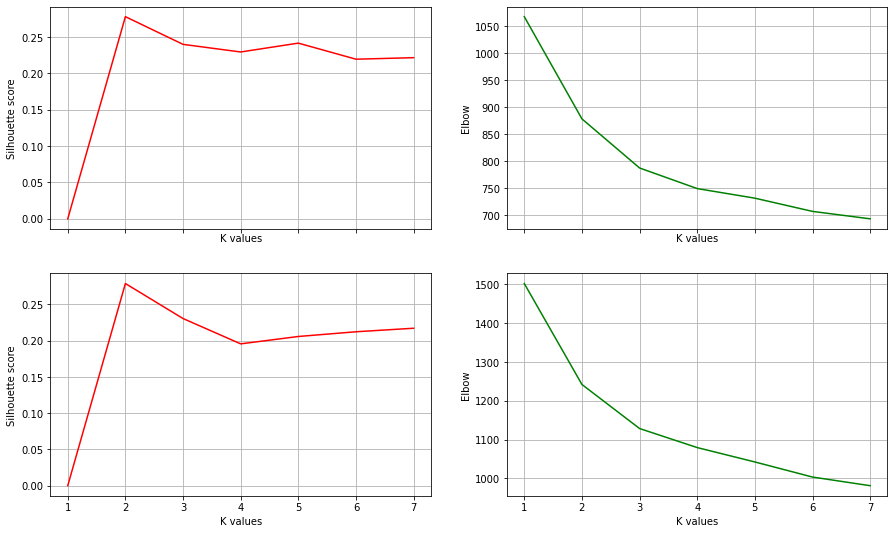

In [13]:
from sklearn.metrics import silhouette_score
# calculate the silhouette
best_k = []

fig, axes = plt.subplots(nrows=len(hidden_layers), ncols=2, sharex=True)
fig.set_size_inches(15, 9)

for hd, ax in zip(hidden_layers,axes):
    sil = []
    sse = []
    kmax = 7

    x = hd
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k, random_state=24).fit(x)
        labels = kmeans.labels_
        if k == 1:
            sil.append(0)
        else:
            sil.append(silhouette_score(x, labels, metric = 'euclidean'))

        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(x)
        curr_sse = 0
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(x)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += np.sqrt(np.sum((x[i] - curr_center) ** 2, axis=0))
        sse.append(curr_sse)
    
    best_k.append(np.array(sil).argmax()+1)
    
    # ploting
    ax[0].plot(range(1,kmax+1),sil,color='r')
    ax[0].set_xlabel('K values')
    ax[0].set_ylabel('Silhouette score')
    ax[1].plot(range(1,kmax+1),sse, color='g')
    ax[1].set_xlabel('K values')
    ax[1].set_ylabel('Elbow')
    
    ax[0].grid(True)
    ax[1].grid(True)
    
if True: #Verbose
    plt.show()
else:
    plt.close(fig)

In [14]:
# Clustering with KMeans
y_kmeans = []
for hd, k in zip(hidden_layers,best_k):
    y_kmeans.append(KMeans(k,n_init=100,random_state=24).fit_predict(hd))

In [19]:
# UMAP
import umap.umap_
import umap.plot

umap.plot.output_notebook()
hover_data = pd.DataFrame({'index':np.arange(len(x_test)),
                           'label':y_train_origin,
                           'prediction': new_r}
                         )

for hd,y_kmean in zip(hidden_layers,y_kmeans):    
    plt.figure(figsize=(15, 5))
    mapper = umap.umap_.UMAP().fit(hd)
    hover_data['kmeans'] = y_kmean
    #t_mapper = mapper.transform(hd)
    #plt.scatter(t_mapper[:,0],t_mapper[:,1], c=y_kmeans, s=50, cmap='viridis')
    #plt.show()
    #p = umap.plot.points(mapper, labels=y_test_origin)
    p = umap.plot.interactive(mapper, labels=y_kmean, hover_data=hover_data,width=800,height=300)
    umap.plot.show(p)



Loading BokehJS ...

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [20]:
import plotly.graph_objects as go
i=0
clusters = []
for k in best_k:
    i += 1
    clusters += ["C"+str(i)+str(j) for j in range(k)]
              
label = keep + clusters + keep + [4]
    
source, target, value = [], [], []
for s, t in zip(y_train_origin, y_kmeans[0]):
    d_source = {1: 0, 7:1}
    d_target = {0: 2, 1:3}
    source.append(d_source[s])
    target.append(d_target[t])
    value.append(s)
    
for s,t,l in zip(y_kmeans[0], y_kmeans[1], y_train_origin):
    d_source = {0: 2, 1:3}
    d_target = {0: 4, 1:5}
    source.append(d_source[s])
    target.append(d_target[t])
    value.append(l)
    
for s,t,l in zip(y_kmeans[1], new_r, y_train_origin):
    d_source = {0: 4, 1:5}
    d_target = {1: 6, 7:7, 4:8}
    source.append(d_source[s])
    target.append(d_target[t])
    value.append(l)
    

In [21]:
node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.25),
      label = label,
      color = "blue"
    )
link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = [1 for t in target],
      label = value
  )

data=[go.Sankey(node=node, link=link)]


fig = go.Figure(data=data)

fig.update_layout(title_text="Basic Sankey Diagram", font_size=15)
fig.show()